# Tutorial 01: CartPole Basic Control

This tutorial demonstrates how to train a reinforcement learning agent on the CartPole balancing task using Myriad's platform.

## Learning Objectives
1. Understand the CartPole environment structure
2. Configure training runs using Hydra configs
3. Train a DQN agent using the platform
4. Analyze training and evaluation results
5. Visualize training progress

**The CartPole task:** Balance a pole on a moving cart by applying left/right forces. Goal: Keep the pole upright for as long as possible (max 500 steps).

## Setup

In [1]:
import jax
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from myriad.configs.default import (
    AgentConfig,
    Config,
    EnvConfig,
    RunConfig,
    WandbConfig,
)
from myriad.envs.cartpole.tasks.control import make_env
from myriad.platform import train_and_evaluate

# Set seaborn style for better-looking plots
sns.set_theme(style="whitegrid", palette="muted")

SEED = 42

---

# Section 1: Understanding the Environment

Let's explore the CartPole environment structure.

## 1.1 Environment Configuration

The environment has two main configurations:
- **Physics Config:** Physical parameters (gravity, masses, pole length, etc.)
- **Task Config:** Task parameters (max steps, termination thresholds)

In [2]:
env = make_env()

print(f"Physics: {env.config.physics}")
print(f"Task: {env.config.task}")

Physics: PhysicsConfig(gravity=9.8, cart_mass=1.0, pole_mass=0.1, pole_length=0.5, force_magnitude=10.0, dt=0.02)
Task: TaskConfig(max_steps=500, theta_threshold=0.2094395102393195, x_threshold=2.4)


## 1.2 Action and Observation Spaces

**Actions:** Discrete(2)
- 0 = push left
- 1 = push right

**Observations:** [x, x_dot, theta, theta_dot]
- x: Cart position (m)
- x_dot: Cart velocity (m/s)
- theta: Pole angle from vertical (rad, 0=upright)
- theta_dot: Pole angular velocity (rad/s)

In [3]:
action_space = env.get_action_space(env.config)
obs_shape = env.get_obs_shape(env.config)

print(f"Action space: Discrete({action_space.n})")
print(f"Observation shape: {obs_shape}")

Action space: Discrete(2)
Observation shape: (4,)


## 1.3 Initial State

The environment returns structured observations as a `PhysicsState` NamedTuple with named fields. This makes it easy to access specific components like `obs.theta` or `obs.x`.

The platform automatically converts these to arrays for efficient training.

In [4]:
key = jax.random.PRNGKey(SEED)
obs, state = env.reset(key, env.params, env.config)

print(f"Observation: {obs}")
print(f"As array: {obs.to_array()}")

Observation: PhysicsState(x=Array(-0.00112904, dtype=float32), x_dot=Array(0.01797972, dtype=float32), theta=Array(0.01162715, dtype=float32), theta_dot=Array(0.00610161, dtype=float32))
As array: [-0.00112904  0.01797972  0.01162715  0.00610161]


## 1.4 Taking Random Actions

In [5]:
for step in range(3):
    key, action_key, step_key = jax.random.split(key, 3)
    action = action_space.sample(action_key)
    next_obs, next_state, reward, done, _ = env.step(
        step_key, state, action, env.params, env.config
    )
    
    print(f"Step {step + 1}: action={action}, theta={next_obs.theta:.4f} rad, reward={reward}, done={done}")
    
    state, obs = next_state, next_obs

Step 1: action=1, theta=0.0117 rad, reward=1.0, done=0.0
Step 2: action=1, theta=0.0061 rad, reward=1.0, done=0.0
Step 3: action=0, theta=-0.0053 rad, reward=1.0, done=0.0


---

# Section 2: Training with the Platform

Now let's train a DQN agent. The platform handles all the complexity:
- Parallel environment execution (JAX vmap)
- Replay buffer management
- Agent updates and target network sync
- Automatic environment resets
- Metrics logging and evaluation

## 2.1 Configure the Training Run

Create a configuration using Pydantic models (same structure as Hydra YAML configs):

In [10]:
config = Config(
    env=EnvConfig(name="cartpole-control"),
    agent=AgentConfig(
        name="pqn",
        hidden_size=256,
        num_layers=2,
        learning_rate=1e-4,
        max_grad_norm=10.0,
        gamma=0.99,
        lambda_=0.95,
        reward_scale=0.1,
        epsilon_start=1.0,
        epsilon_end=0.2,
        epsilon_decay_steps=50,
        num_epochs=4,
        num_minibatches=16,
    ),
    run=RunConfig(
        seed=SEED,
        num_envs=32,
        steps_per_env=int(5e5 / 32),  # 20000 steps/env * 16 envs = 320k total
        log_frequency=640,
        eval_frequency=640,
        eval_max_steps=512,
        eval_rollouts=10,
        scan_chunk_size=256,
        rollout_steps=64,
    ),
    wandb=WandbConfig(enabled=False),
)

print(f"Training {config.run.total_timesteps:,} total steps ({config.run.steps_per_env:,} steps per env × {config.run.num_envs} envs)")
print(f"Evaluating performance every {config.run.eval_frequency} steps per env")
print(f"Logging training metrics every {config.run.log_frequency} steps per env")

Training 500,000 total steps (15,625 steps per env × 32 envs)
Evaluating performance every 640 steps per env
Logging training metrics every 640 steps per env


## 2.2 Run Training

**This will take a few seconds:**

In [11]:
results = train_and_evaluate(config)

Training: 100%|██████████| 15625/15625 [02:08<00:00, 121.79steps/s] , loss=0.000, eval_return=19.80


## 2.3 Training Summary

In [39]:
print(f"Total timesteps: {results.training_metrics.global_steps[-1]:,}")

Total timesteps: 643,072


---

# Section 3: Analyzing Results

The platform returns complete `TrainingResults` with all metrics.

## 3.1 Training Metrics

In [42]:
results.training_metrics

TrainingMetrics(global_steps=[512000, 643072], steps_per_env=[16000, 20096], loss=[18.888565063476562, 17.845556259155273], reward=None, agent_metrics={'lambda_return_mean': [15.480941772460938, 16.641864776611328], 'q_value': [15.542046546936035, 16.140560150146484], 'td_error': [3.235722541809082, 3.1511213779449463]})

In [41]:
print(f"Initial loss: {results.training_metrics.loss[0]:.4f}")
print(f"Final loss: {results.training_metrics.loss[-1]:.4f}")

td_errors = results.training_metrics.agent_metrics["td_error"]
print(f"Initial TD error: {td_errors[0]:.4f}")
print(f"Final TD error: {td_errors[-1]:.4f}")

q_values = results.training_metrics.agent_metrics["q_value"]
print(f"Initial Q-value: {q_values[0]:.4f}")
print(f"Final Q-value: {q_values[-1]:.4f}")

Initial loss: 18.8886
Final loss: 17.8456
Initial TD error: 3.2357
Final TD error: 3.1511
Initial Q-value: 15.5420
Final Q-value: 16.1406


## 3.2 Evaluation Metrics

In [43]:
for i, (step, mean_ret, std_ret, mean_len) in enumerate(
    zip(
        results.eval_metrics.steps_per_env,
        results.eval_metrics.mean_return,
        results.eval_metrics.std_return,
        results.eval_metrics.mean_length,
    )
):
    print(f"Evaluation {i + 1} @ {step:,} steps (per env): {mean_ret:.1f} ± {std_ret:.1f} (episode length: {mean_len:.0f})")

Evaluation 1 @ 16,000 steps (per env): 21.8 ± 7.0 (episode length: 22)


## 3.3 Performance Summary

In [44]:
results.summary()

{'final_eval_return_mean': 21.799999237060547,
 'final_eval_return_std': 6.954135417938232,
 'total_training_steps': 643072,
 'num_eval_checkpoints': 1}

---

# Section 4: Visualizing Progress

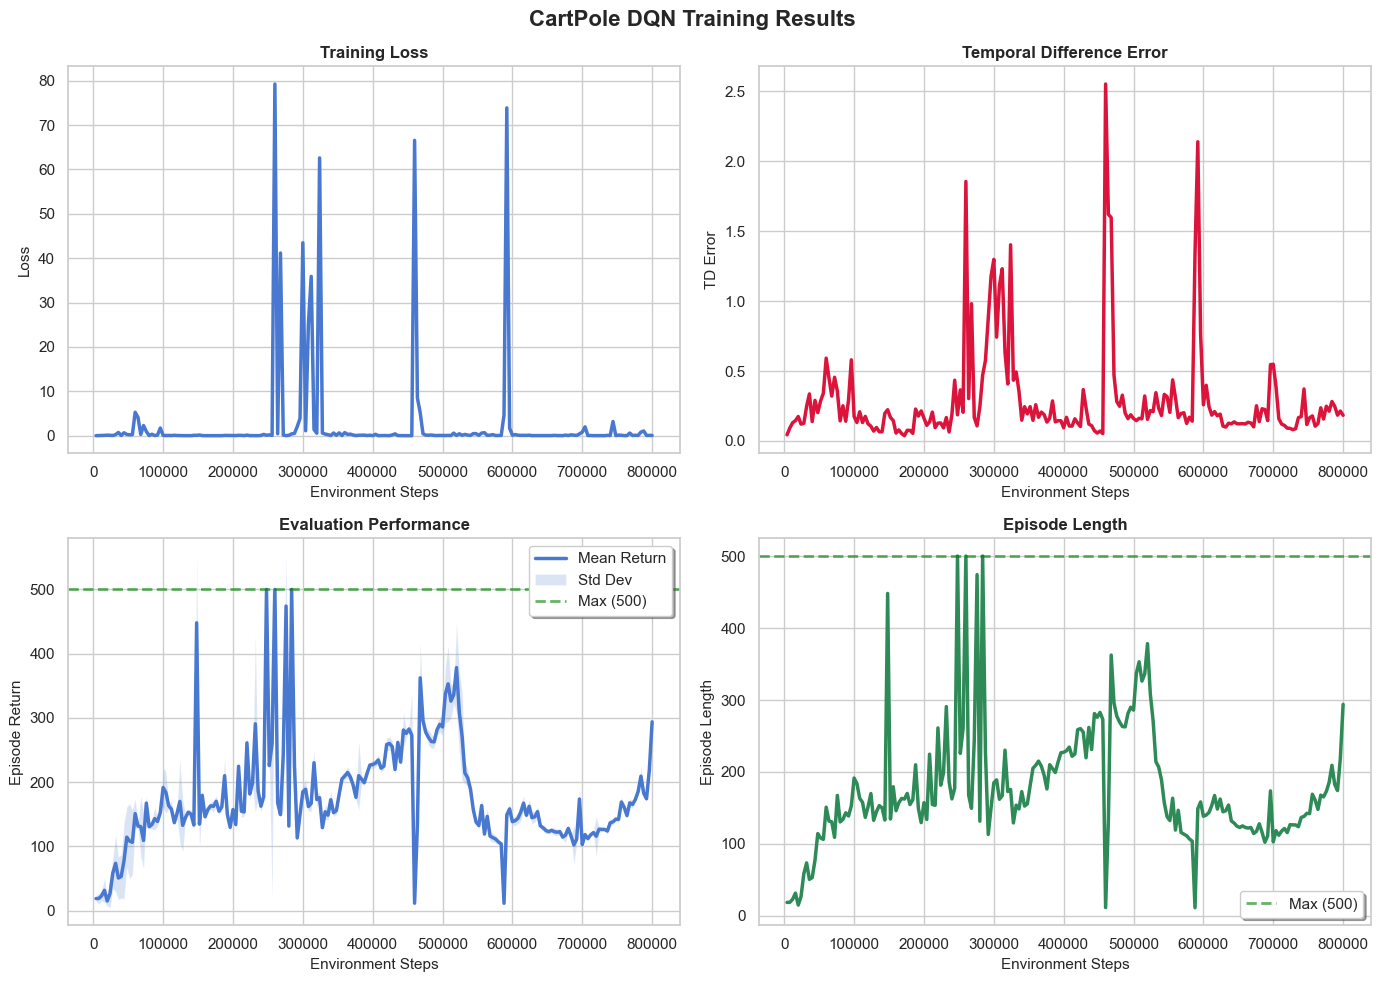

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("CartPole DQN Training Results", fontsize=16, fontweight="bold")

# Training Loss
ax = axes[0, 0]
sns.lineplot(
    x=results.training_metrics.global_steps,
    y=results.training_metrics.loss,
    linewidth=2.5,
    ax=ax,
)
ax.set_xlabel("Environment Steps", fontsize=11)
ax.set_ylabel("Loss", fontsize=11)
ax.set_title("Training Loss", fontweight="bold", fontsize=12)

# TD Error
ax = axes[0, 1]
sns.lineplot(
    x=results.training_metrics.global_steps,
    y=results.training_metrics.agent_metrics["td_error"],
    linewidth=2.5,
    ax=ax,
    color="crimson",
)
ax.set_xlabel("Environment Steps", fontsize=11)
ax.set_ylabel("TD Error", fontsize=11)
ax.set_title("Temporal Difference Error", fontweight="bold", fontsize=12)

# Evaluation Returns
ax = axes[1, 0]
steps = results.eval_metrics.global_steps
mean_ret = np.array(results.eval_metrics.mean_return)
std_ret = np.array(results.eval_metrics.std_return)

sns.lineplot(x=steps, y=mean_ret, linewidth=2.5, ax=ax, label="Mean Return")
ax.fill_between(
    steps,
    mean_ret - std_ret,
    mean_ret + std_ret,
    alpha=0.2,
    label="Std Dev",
)
ax.axhline(y=500, color="green", linestyle="--", linewidth=2, alpha=0.6, label="Max (500)")
ax.set_xlabel("Environment Steps", fontsize=11)
ax.set_ylabel("Episode Return", fontsize=11)
ax.set_title("Evaluation Performance", fontweight="bold", fontsize=12)
ax.legend(frameon=True, shadow=True)

# Episode Lengths
ax = axes[1, 1]
sns.lineplot(
    x=results.eval_metrics.global_steps,
    y=results.eval_metrics.mean_length,
    linewidth=2.5,
    ax=ax,
    color="seagreen",
)
ax.axhline(y=500, color="green", linestyle="--", linewidth=2, alpha=0.6, label="Max (500)")
ax.set_xlabel("Environment Steps", fontsize=11)
ax.set_ylabel("Episode Length", fontsize=11)
ax.set_title("Episode Length", fontweight="bold", fontsize=12)
ax.legend(frameon=True, shadow=True)

plt.tight_layout()
plt.show()

---

# Tutorial Complete!

## What You Learned
1. How to explore CartPole environment structure
2. How to configure training runs using `Config` objects
3. How to train agents using `train_and_evaluate()`
4. How to access and analyze `TrainingResults`
5. How to visualize training progress

## Next Steps
Try experimenting with:
- Different hyperparameters (`learning_rate`, `epsilon_decay`, etc.)
- More parallel environments (`num_envs`)
- Longer training per env (`steps_per_env`)
- W&B logging (`wandb.enabled=True`)
- Other agents (PPO, SAC) when available